In [1]:
!pip install kagglehub
!pip install tensorflow
!pip install category_encoders
!pip install hdbscan
!pip install --upgrade numexpr bottleneck
!pip install numpy==1.26 --user
!pip install --upgrade matplotlib
!pip install --upgrade seaborn
!pip install xgboost

In [2]:
import kagglehub

path = kagglehub.dataset_download("shivamb/bank-customer-segmentation")

print("Path to dataset files:", path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
import random
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/shivamb/bank-customer-segmentation/versions/1


In [3]:
def load_data(train_path):
    print("Loading datasets...")
    df_train = pd.read_csv(train_path)
    print(f"Training dataset loaded with shape: {df_train.shape}")

    return df_train

In [4]:
def exploratory_data_analysis(df_train, df_test=None):
    """Perform exploratory data analysis on the datasets."""
    print("\n==== Exploratory Data Analysis ====")

    print("\nTraining Dataset Information:")
    print(f"Number of rows: {df_train.shape[0]}")
    print(f"Number of columns: {df_train.shape[1]}")

    print("\nColumn names (Training):")
    print(df_train.columns.tolist())

    print("\nSample data (Training):")
    print(df_train.head())

    print("\nData types (Training):")
    print(df_train.dtypes)

    print("\nMissing values (Training):")
    print(df_train.isnull().sum())

    print("\nSummary statistics (Training):")
    print(df_train.describe())

    if df_test is not None:
        print("\nTest dataset information:")
        print(f"Number of rows: {df_test.shape[0]}")
        print(f"Number of columns: {df_test.shape[1]}")

        print("\nColumn names (Test):")
        print(df_test.columns.tolist())

        print("\nSample data (Test):")
        print(df_test.head())

        print("\nMissing values (Test):")
        print(df_test.isnull().sum())

        print("\nSummary statistics (Test):")
        print(df_test.describe())

        train_cols = set(df_train.columns)
        test_cols = set(df_test.columns)

        if train_cols == test_cols:
            print("\nTrain and test datasets have the same columns.")
        else:
            print("\nDifferences in columns between train and test datasets:")
            print(f"Columns in train but not in test: {train_cols - test_cols}")
            print(f"Columns in test but not in train: {test_cols - train_cols}")

    return df_train, df_test

In [5]:
import pandas as pd
from datetime import datetime
def clean_data(df):

  df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace(r'[()]', '', regex=True)

  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], dayfirst=True, errors='coerce')
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], dayfirst=True, errors='coerce')

  df['CustGender'] = df['CustGender'].fillna('Unknown')
  df['CustLocation'] = df['CustLocation'].fillna('Unknown')
  df['CustAccountBalance'] = df['CustAccountBalance'].fillna(df['CustAccountBalance'].median())
  df['CustomerDOB'] = df['CustomerDOB'].fillna(pd.to_datetime('1970-01-01'))
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')

  df = df[df['CustomerDOB'].notna()]

  df['Age'] = df['CustomerDOB'].apply(lambda dob: 2016 - dob.year)

  df['TransactionTime'] = df['TransactionTime'].astype(str).str.zfill(6)
  df['TransactionHour'] = df['TransactionTime'].str[:2].astype(int)
  df['TransactionMinute'] = df['TransactionTime'].str[2:4].astype(int)
  df['TransactionSecond'] = df['TransactionTime'].str[4:6].astype(int)

  df['TransactionDateTime'] = pd.to_datetime(df['TransactionDate'].dt.strftime('%Y-%m-%d') + ' ' +
                                           df['TransactionHour'].astype(str).str.zfill(2) + ':' +
                                           df['TransactionMinute'].astype(str).str.zfill(2) + ':' +
                                           df['TransactionSecond'].astype(str).str.zfill(2),
                                           errors='coerce')

  df = df.drop(columns=['TransactionTime'])

  df = df[df['TransactionAmount_INR'] > 0]

  df = df.dropna(subset=['TransactionDateTime'])

  df = df.reset_index(drop=True)

  return df


In [6]:
df_train = load_data(path + "/bank_transactions.csv")


exploratory_data_analysis(df_train)


Loading datasets...
Training dataset loaded with shape: (1048567, 9)

==== Exploratory Data Analysis ====

Training Dataset Information:
Number of rows: 1048567
Number of columns: 9

Column names (Training):
['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance', 'TransactionDate', 'TransactionTime', 'TransactionAmount (INR)']

Sample data (Training):
  TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053     10/1/94          F   JAMSHEDPUR   
1            T2   C2142763      4/4/57          M      JHAJJAR   
2            T3   C4417068    26/11/96          F       MUMBAI   
3            T4   C5342380     14/9/73          F       MUMBAI   
4            T5   C9031234     24/3/88          F  NAVI MUMBAI   

   CustAccountBalance TransactionDate  TransactionTime  \
0            17819.05          2/8/16           143207   
1             2270.69          2/8/16           141858   
2            17874.44          2

(        TransactionID CustomerID CustomerDOB CustGender   CustLocation  \
 0                  T1   C5841053     10/1/94          F     JAMSHEDPUR   
 1                  T2   C2142763      4/4/57          M        JHAJJAR   
 2                  T3   C4417068    26/11/96          F         MUMBAI   
 3                  T4   C5342380     14/9/73          F         MUMBAI   
 4                  T5   C9031234     24/3/88          F    NAVI MUMBAI   
 ...               ...        ...         ...        ...            ...   
 1048562      T1048563   C8020229      8/4/90          M      NEW DELHI   
 1048563      T1048564   C6459278     20/2/92          M         NASHIK   
 1048564      T1048565   C6412354     18/5/89          M      HYDERABAD   
 1048565      T1048566   C6420483     30/8/78          M  VISAKHAPATNAM   
 1048566      T1048567   C8337524      5/3/84          M           PUNE   
 
          CustAccountBalance TransactionDate  TransactionTime  \
 0                  17819.05     

In [7]:
df_train = clean_data(df_train)

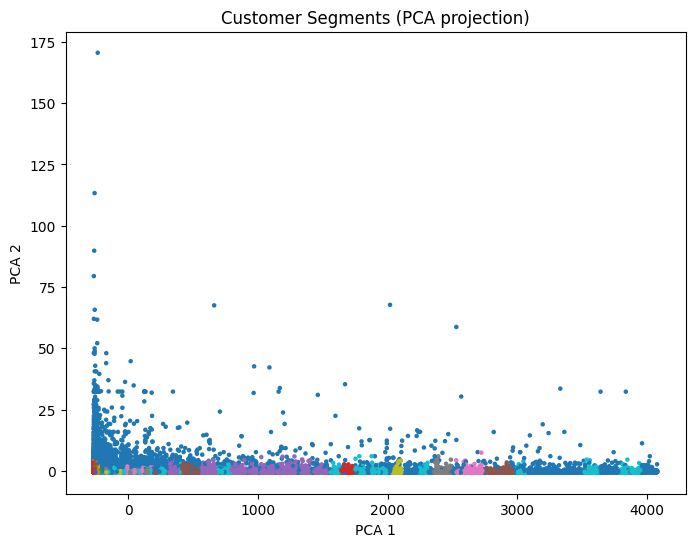

         TotalSpend  AvgSpend   MaxTxn  NumTxns  AvgBalance  ActivitySpan
cluster                                                                  
-1          6786.44   6602.86  6744.78     1.08   427962.20          1.29
 0          1229.97   1229.97  1229.97     1.00    52581.06          0.00
 1          1128.33   1127.03  1127.33     1.00    80285.83          0.00
 2          1635.09   1635.09  1635.09     1.00    97643.98          0.00
 3          1103.66   1103.66  1103.66     1.00    64852.56          0.00
...             ...       ...      ...      ...         ...           ...
 140         820.43    820.43   820.43     1.00    52766.45          0.00
 141         885.23    885.23   885.23     1.00    63059.37          0.00
 142         960.30    960.30   960.30     1.00    67714.59          0.00
 143         818.67    818.67   818.67     1.00    38111.40          0.00
 144        1034.44   1034.44  1034.44     1.00    93158.05          0.00

[146 rows x 6 columns]


In [8]:
 !pip install hdbscan category_encoders
import pandas as pd
import time
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import hdbscan
from sklearn.cluster import MiniBatchKMeans
import category_encoders as ce

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = df_train.copy()
df = df.sample(n=100000, random_state=42)

customer_df = df.groupby('CustomerID').agg({
    'TransactionAmount_INR': ['mean', 'sum', 'count', 'max'],
    'CustAccountBalance': 'mean',
    'TransactionDateTime': ['min', 'max'],
    'CustLocation': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
})
customer_df.columns = ['_'.join(col).strip() for col in customer_df.columns.values]
customer_df = customer_df.reset_index()

customer_df['TotalSpend'] = customer_df['TransactionAmount_INR_sum']
customer_df['AvgSpend'] = customer_df['TransactionAmount_INR_mean']
customer_df['NumTxns'] = customer_df['TransactionAmount_INR_count']
customer_df['MaxTxn'] = customer_df['TransactionAmount_INR_max']
customer_df['AvgBalance'] = customer_df['CustAccountBalance_mean']
customer_df['Location'] = customer_df['CustLocation_<lambda>']

customer_df['ActivitySpan'] = (
    customer_df['TransactionDateTime_max'] - customer_df['TransactionDateTime_min']
).dt.days

customer_df['AvgDaysBetweenTxns'] = customer_df['ActivitySpan'] / customer_df['NumTxns']

latest_date = df['TransactionDateTime'].max()
recent_cutoff = latest_date - pd.Timedelta(days=30)
recent_activity = df[df['TransactionDateTime'] >= recent_cutoff].groupby('CustomerID').size()
customer_df['RecentActivity'] = customer_df['CustomerID'].map(recent_activity).fillna(0)

txn_std = df.groupby('CustomerID')['TransactionAmount_INR'].std()
customer_df['TxnAmountStd'] = customer_df['CustomerID'].map(txn_std).fillna(0)

customer_df['SpendPerDay'] = customer_df['TotalSpend'] / (customer_df['ActivitySpan'] + 1)
customer_df['TxnPerDay'] = customer_df['NumTxns'] / (customer_df['ActivitySpan'] + 1)

customer_df = customer_df.drop(columns=[
    'TransactionAmount_INR_sum',
    'TransactionAmount_INR_mean',
    'TransactionAmount_INR_count',
    'TransactionAmount_INR_max',
    'CustAccountBalance_mean',
    'TransactionDateTime_min',
    'TransactionDateTime_max',
    'CustLocation_<lambda>'
])

categorical_cols = ['Location']
numeric_cols = customer_df.drop(columns=['CustomerID', 'Location']).columns.tolist()

encoder = ce.OrdinalEncoder(cols=categorical_cols)
scaler = StandardScaler()

customer_encoded = encoder.fit_transform(customer_df)
customer_scaled = customer_encoded.copy()
customer_scaled[numeric_cols] = scaler.fit_transform(customer_encoded[numeric_cols])

clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=50, prediction_data=True)
customer_df['cluster'] = clusterer.fit_predict(customer_scaled[numeric_cols + categorical_cols])

cluster_sizes = customer_df['cluster'].value_counts()

MIN_CLUSTER_SIZE = 200
small_clusters = cluster_sizes[cluster_sizes < MIN_CLUSTER_SIZE].index

customer_df['cluster_cleaned'] = customer_df['cluster'].apply(
    lambda x: 'Other' if x in small_clusters else x
)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(customer_scaled[numeric_cols + categorical_cols])

plot_labels = LabelEncoder().fit_transform(customer_df['cluster_cleaned'].astype(str))

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=plot_labels, cmap='tab10', s=5)
plt.title("Customer Segments (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

summary = customer_df.groupby('cluster').agg({
    'TotalSpend': 'mean',
    'AvgSpend': 'mean',
    'MaxTxn': 'mean',
    'NumTxns': 'mean',
    'AvgBalance': 'mean',
    'ActivitySpan': 'mean'
}).round(2)

print(summary)

In [9]:
import pandas as pd
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

df_train_txn, df_test_txn = train_test_split(df, test_size=0.2, random_state=42)

latest_date_train = df_train_txn['TransactionDateTime'].max()
recent_cutoff_train = latest_date_train - pd.Timedelta(days=30)

recent_activity_train = df_train_txn[df_train_txn['TransactionDateTime'] >= recent_cutoff_train] \
    .groupby('CustomerID').size()
customer_df['RecentActivity'] = customer_df['CustomerID'].map(recent_activity_train).fillna(0)

cutoff_date = df['TransactionDateTime'].max() - pd.Timedelta(days=30)
last_txn_date = df.groupby('CustomerID')['TransactionDateTime'].max()
customer_df['Churn'] = (last_txn_date < cutoff_date).astype(int).values

customer_df['CLV'] = customer_df['TotalSpend']

features = ['TotalSpend', 'AvgSpend', 'NumTxns', 'MaxTxn', 'AvgBalance',
            'ActivitySpan', 'RecentActivity', 'TxnAmountStd',
            'SpendPerDay', 'TxnPerDay', 'cluster']
X = customer_df[features]
y_clv = customer_df['CLV']
y_churn = customer_df['Churn']

X_train, X_test, y_clv_train, y_clv_test, y_churn_train, y_churn_test = train_test_split(
    X, y_clv, y_churn, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clv_model = RandomForestRegressor(n_estimators=100, random_state=42)
churn_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)
clv_model.fit(X_train_scaled, y_clv_train)
y_clv_pred = clv_model.predict(X_test_scaled)
clv_rmse = sqrt(mean_squared_error(y_clv_test, y_clv_pred))
print(f"CLV prediction RMSE: {clv_rmse:.2f}")

churn_model = RandomForestClassifier(n_estimators=100, random_state=42)
churn_model.fit(X_train_scaled, y_churn_train)
y_churn_pred = churn_model.predict(X_test_scaled)

churn_accuracy = accuracy_score(y_churn_test, y_churn_pred)
print(f"Churn prediction Accuracy: {churn_accuracy:.2%}")
print(classification_report(y_churn_test, y_churn_pred))


CLV prediction RMSE: 362.34
Churn prediction Accuracy: 99.56%
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       821
           1       1.00      1.00      1.00     18845

    accuracy                           1.00     19666
   macro avg       0.98      0.96      0.97     19666
weighted avg       1.00      1.00      1.00     19666



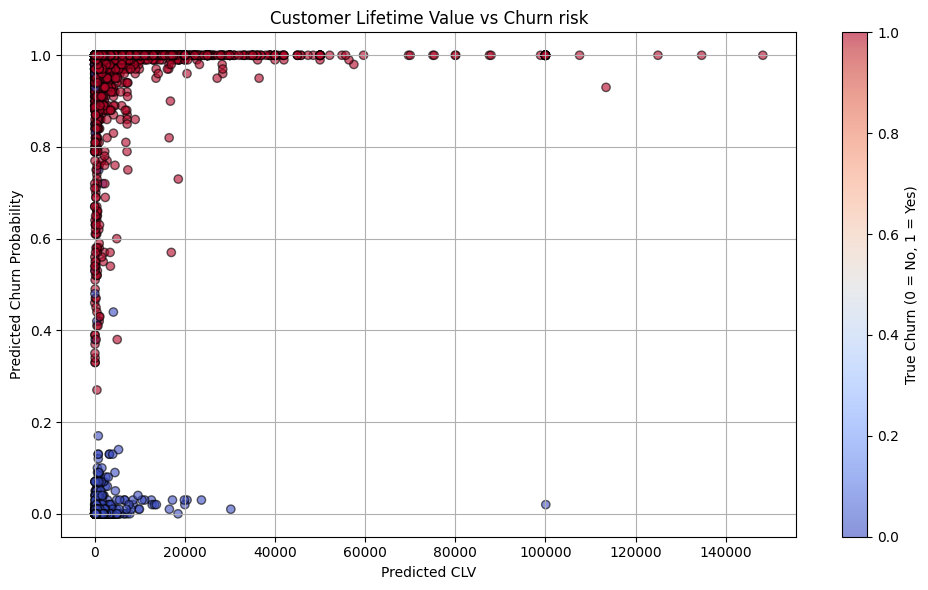

In [10]:
# Predict CLV and churn probability
y_clv_pred = clv_model.predict(X_test_scaled)
y_churn_pred_proba = churn_model.predict_proba(X_test_scaled)[:, 1]

# Display CLV vs Churn Risk
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    y_clv_pred,
    y_churn_pred_proba,
    c=y_churn_test,
    cmap='coolwarm',
    edgecolor='k',
    alpha=0.6
)
plt.colorbar(scatter, label="True Churn (0 = No, 1 = Yes)")
plt.title("Customer Lifetime Value vs Churn risk")
plt.xlabel("Predicted CLV")
plt.ylabel("Predicted Churn Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:

# XGBoost – CLV & Churn Models

from xgboost import XGBRegressor, XGBClassifier

xgb_clv_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb_clv_model.fit(X_train_scaled, y_clv_train)
y_clv_pred_xgb = xgb_clv_model.predict(X_test_scaled)

xgb_clv_rmse = sqrt(mean_squared_error(y_clv_test, y_clv_pred_xgb))
print(f" XGBoost CLV Prediction RMSE: {xgb_clv_rmse:.2f}")

xgb_churn_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_churn_model.fit(X_train_scaled, y_churn_train)
y_churn_pred_xgb = xgb_churn_model.predict(X_test_scaled)

xgb_churn_accuracy = accuracy_score(y_churn_test, y_churn_pred_xgb)
print(f"XGBoost Churn Prediction Accuracy: {xgb_churn_accuracy:.2%}")
print(classification_report(y_churn_test, y_churn_pred_xgb))


 XGBoost CLV Prediction RMSE: 1728.25
XGBoost Churn Prediction Accuracy: 99.64%
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       821
           1       1.00      1.00      1.00     18845

    accuracy                           1.00     19666
   macro avg       1.00      0.96      0.98     19666
weighted avg       1.00      1.00      1.00     19666



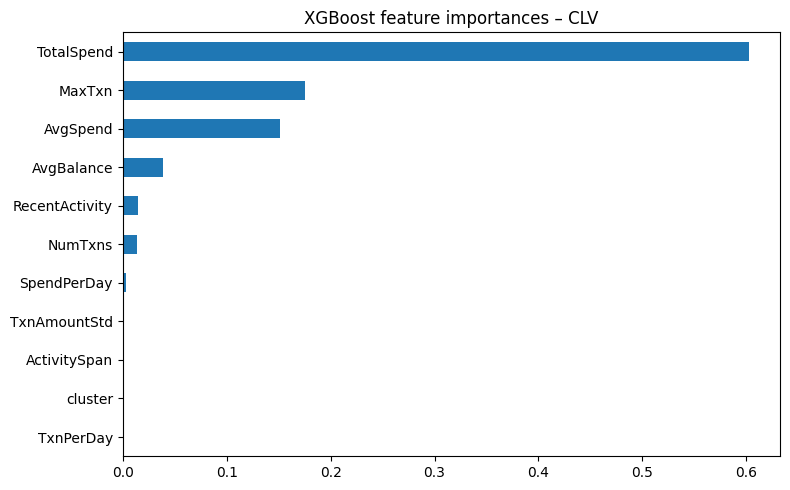

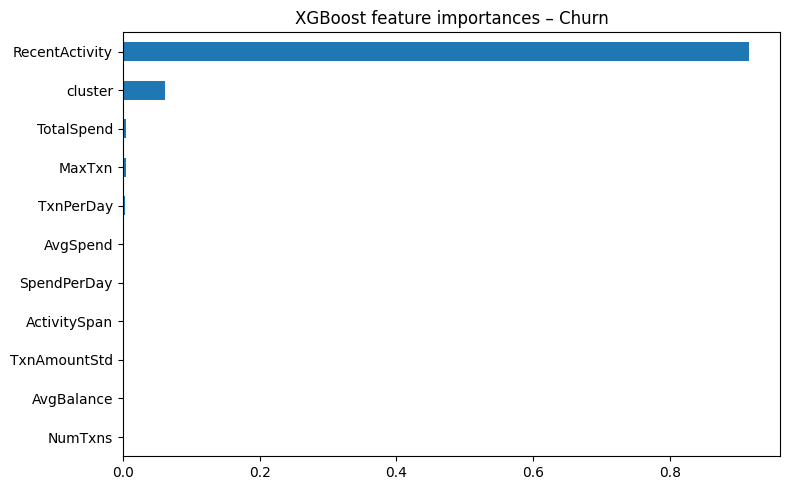

In [12]:
#feature imporatance
import pandas as pd
import matplotlib.pyplot as plt

# CLV
pd.Series(xgb_clv_model.feature_importances_, index=X.columns).sort_values().plot(kind='barh', figsize=(8, 5))
plt.title("XGBoost feature importances – CLV")
plt.tight_layout()
plt.show()

# Churn
pd.Series(xgb_churn_model.feature_importances_, index=X.columns).sort_values().plot(kind='barh', figsize=(8, 5))
plt.title("XGBoost feature importances – Churn")
plt.tight_layout()
plt.show()


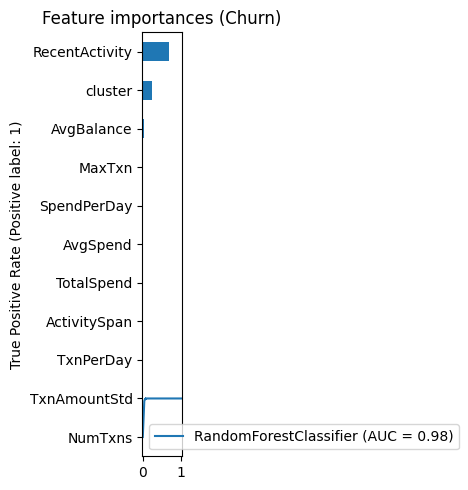

In [13]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
RocCurveDisplay.from_estimator(churn_model, X_test_scaled, y_churn_test)

importances = churn_model.feature_importances_
pd.Series(importances, index=X.columns).sort_values().plot(kind='barh', figsize=(8,5))
plt.title("Feature importances (Churn)")
plt.tight_layout()
plt.show()


Silhouette Score (HDBSCAN, filtered): 0.6547
Total clusters (excluding noise): 145
Noise points: 10931 (11.12%)
Cluster size stats (non-noise):
count     145.000000
mean      602.744828
std      1329.100264
min       100.000000
25%       160.000000
50%       230.000000
75%       381.000000
max      8961.000000
Name: count, dtype: float64


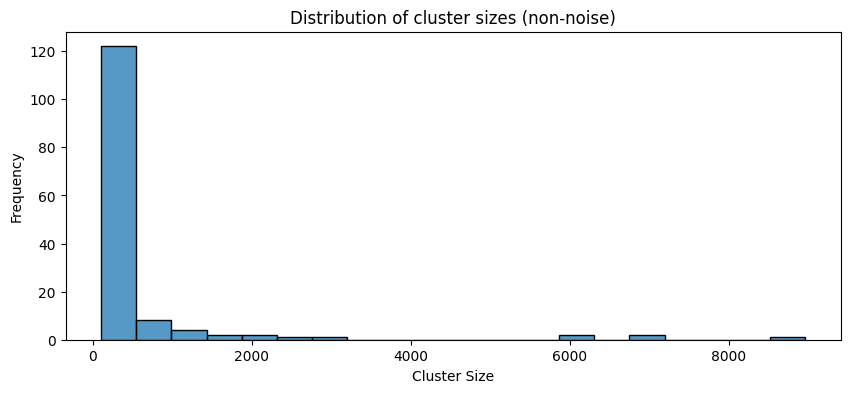

In [14]:
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt


valid = customer_df[customer_df['cluster'] != -1]
silhouette = silhouette_score(customer_scaled.loc[valid.index, numeric_cols + categorical_cols], valid['cluster'])
print(f"Silhouette Score (HDBSCAN, filtered): {silhouette:.4f}")

cluster_counts = customer_df['cluster'].value_counts().sort_index()
noise_count = cluster_counts.get(-1, 0)
num_clusters = len(cluster_counts) - (1 if -1 in cluster_counts else 0)
total = len(customer_df)

print(f"Total clusters (excluding noise): {num_clusters}")
print(f"Noise points: {noise_count} ({noise_count / total:.2%})")

non_noise_clusters = customer_df[customer_df['cluster'] != -1]['cluster'].value_counts()
print("Cluster size stats (non-noise):")
print(non_noise_clusters.describe())

plt.figure(figsize=(10, 4))
sns.histplot(non_noise_clusters, bins=20)
plt.title("Distribution of cluster sizes (non-noise)")
plt.xlabel("Cluster Size")
plt.ylabel("Frequency")
plt.show()

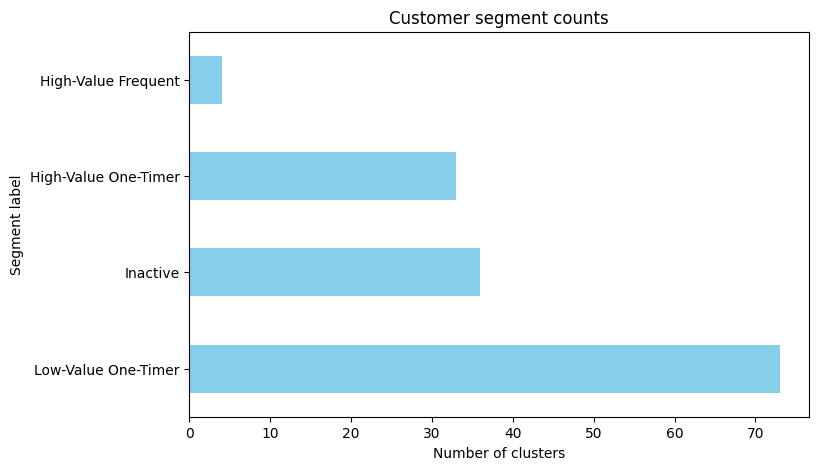

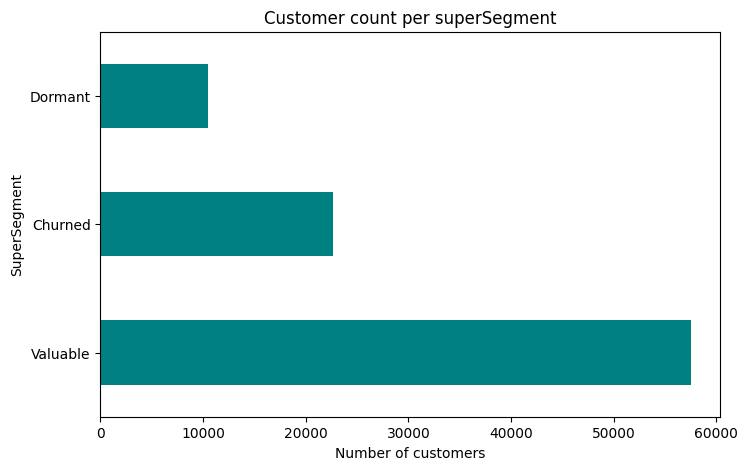

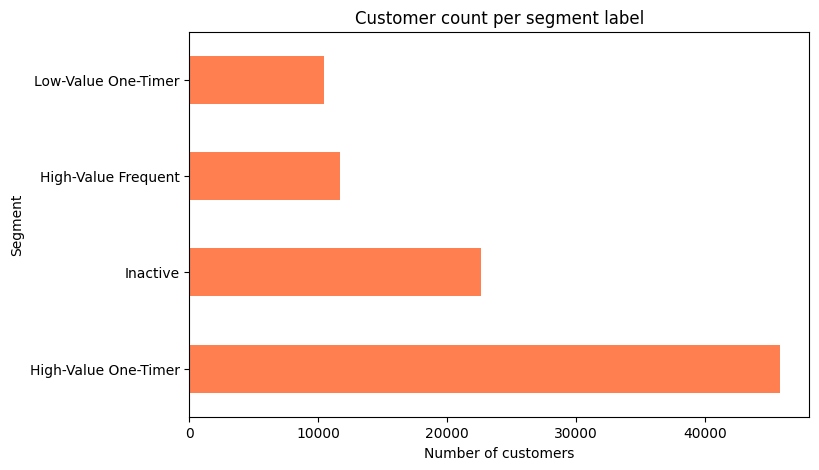

In [15]:

numeric_summary = summary.select_dtypes(include='number')
q = numeric_summary.quantile([0.25, 0.5, 0.75])

def label_cluster(row):
    if row['TotalSpend'] > q.loc[0.75, 'TotalSpend'] and row['NumTxns'] > q.loc[0.75, 'NumTxns']:
        return "High-Value Frequent"
    elif row['TotalSpend'] > q.loc[0.75, 'TotalSpend']:
        return "High-Value One-Timer"
    elif row['TotalSpend'] > q.loc[0.50, 'TotalSpend'] and row['NumTxns'] > q.loc[0.50, 'NumTxns']:
        return "Mid-Value Engaged"
    elif row['ActivitySpan'] > q.loc[0.75, 'ActivitySpan']:
        return "Returning Customer"
    elif row['NumTxns'] == 1 and row['TotalSpend'] < q.loc[0.50, 'TotalSpend']:
        return "Low-Value One-Timer"
    else:
        return "Inactive"

def super_label(label):
    if "High-Value" in label:
        return "Valuable"
    elif "Mid-Value" in label:
        return "Growth"
    elif "Returning" in label:
        return "Loyal"
    elif "Low-Value" in label:
        return "Dormant"
    elif "Inactive" in label:
        return "Churned"
    else:
        return "Other"

summary['Label'] = summary.apply(label_cluster, axis=1)
summary['SuperSegment'] = summary['Label'].apply(super_label)

customer_labeled = customer_df.merge(
    summary[['Label', 'SuperSegment']],
    left_on='cluster_cleaned',
    right_index=True,
    how='left'
)

summary['Label'].value_counts().plot(kind='barh', figsize=(8, 5), color='skyblue')
plt.title("Customer segment counts")
plt.xlabel("Number of clusters")
plt.ylabel("Segment label")
plt.show()

customer_labeled['SuperSegment'].value_counts().plot(kind='barh', figsize=(8, 5), color='teal')
plt.title("Customer count per superSegment")
plt.xlabel("Number of customers")
plt.ylabel("SuperSegment")
plt.show()

customer_labeled['Label'].value_counts().plot(kind='barh', figsize=(8, 5), color='coral')
plt.title("Customer count per segment label")
plt.xlabel("Number of customers")
plt.ylabel("Segment")
plt.show()


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

X = customer_scaled[numeric_cols + categorical_cols]
y = customer_labeled['SuperSegment']

df_model = X.copy()
df_model['SuperSegment'] = y
df_model = df_model.dropna(subset=['SuperSegment'])

X = df_model.drop(columns=['SuperSegment'])
y = df_model['SuperSegment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

     Churned       0.93      0.91      0.92      4528
     Dormant       0.77      0.84      0.80      2088
    Valuable       0.97      0.96      0.97     11505

    accuracy                           0.94     18121
   macro avg       0.89      0.90      0.90     18121
weighted avg       0.94      0.94      0.94     18121



In [17]:
print(customer_labeled['SuperSegment'].value_counts())


def simulate_conversion_uplift(df, from_segment="Dormant", to_segment="Loyal", metric="TotalSpend", conversion_rate=0.10):
    """
    Estimate revenue uplift if a % of 'from_segment' customers behaved like 'to_segment' customers.
    """
    from_group = df[df['SuperSegment'] == from_segment]
    to_group = df[df['SuperSegment'] == to_segment]

    if from_group.empty or to_group.empty:
        raise ValueError("One of the segments is empty. Check spelling or distribution.")

    from_avg = from_group[metric].mean()
    to_avg = to_group[metric].mean()
    uplift_per_customer = to_avg - from_avg
    n_converted = int(len(from_group) * conversion_rate)
    total_uplift = uplift_per_customer * n_converted

    print(f"\n--- Conversion simulation: {int(conversion_rate*100)}% {from_segment} ➝ {to_segment} ---")
    print(f"Avg {metric} (from): €{from_avg:.2f}")
    print(f"Avg {metric} (to):   €{to_avg:.2f}")
    print(f"Per-Customer Uplift: €{uplift_per_customer:.2f}")
    print(f"Converted Customers: {n_converted}")
    print(f"Total Uplift:        €{total_uplift:,.2f}")

    return {
        "from_segment": from_segment,
        "to_segment": to_segment,
        "conversion_rate": conversion_rate,
        "uplift_per_customer": uplift_per_customer,
        "converted_customers": n_converted,
        "total_uplift": total_uplift
    }

# Example
simulate_conversion_uplift(customer_labeled, from_segment="Dormant", to_segment="Valuable", metric="TotalSpend", conversion_rate=0.10)


SuperSegment
Valuable    57523
Churned     22638
Dormant     10443
Name: count, dtype: int64

--- Conversion simulation: 10% Dormant ➝ Valuable ---
Avg TotalSpend (from): €668.89
Avg TotalSpend (to):   €2177.04
Per-Customer Uplift: €1508.16
Converted Customers: 1044
Total Uplift:        €1,574,513.89


{'from_segment': 'Dormant',
 'to_segment': 'Valuable',
 'conversion_rate': 0.1,
 'uplift_per_customer': 1508.155067131419,
 'converted_customers': 1044,
 'total_uplift': 1574513.8900852015}

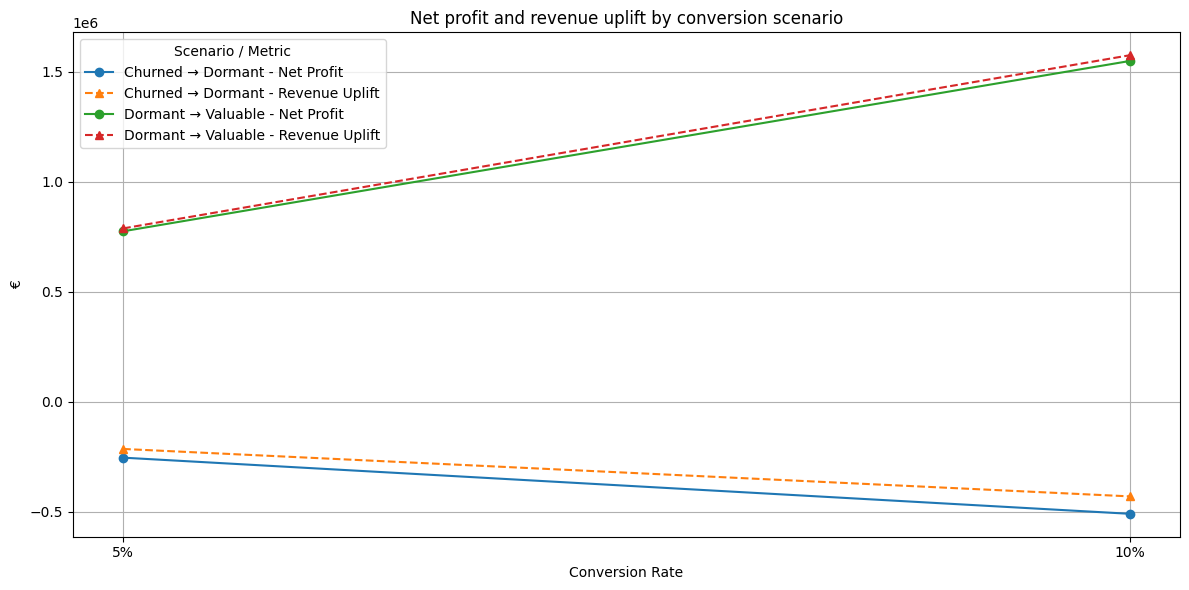

,From → To,Conversion Rate,Customers converted,Total Revenue Uplift (€),Total Cost (€),Net Profit (€)
0,Dormant → Valuable,5%,522,787256.95,13050,774206.95
1,Dormant → Valuable,10%,1044,1574513.89,26100,1548413.89
2,Churned → Dormant,5%,1131,-215417.80,39585,-255002.80
3,Churned → Dormant,10%,2263,-431026.08,79205,-510231.08


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# get the segment stats
segment_stats = (
    customer_labeled
    .groupby("SuperSegment")
    .agg(count=("SuperSegment", "count"), avg_spend=("TotalSpend", "mean"))
    .to_dict(orient="index")
)

conversion_scenarios = [
    ("Dormant", "Valuable", 0.05),
    ("Dormant", "Valuable", 0.10),
    ("Churned", "Dormant", 0.05),
    ("Churned", "Dormant", 0.10)
]

conversion_costs = {
    ("Dormant", "Valuable"): 25,
    ("Churned", "Dormant"): 35
}

results = []
for from_seg, to_seg, rate in conversion_scenarios:
    from_data = segment_stats[from_seg]
    to_data = segment_stats[to_seg]
    cost_per_conversion = conversion_costs.get((from_seg, to_seg), 25)

    uplift_per_customer = to_data["avg_spend"] - from_data["avg_spend"]
    n_converted = int(from_data["count"] * rate)
    total_uplift = uplift_per_customer * n_converted
    total_cost = cost_per_conversion * n_converted
    net_profit = total_uplift - total_cost

    results.append({
        "From → To": f"{from_seg} → {to_seg}",
        "Conversion Rate": f"{int(rate * 100)}%",
        "Customers converted": n_converted,
        "Total Revenue Uplift (€)": round(total_uplift, 2),
        "Total Cost (€)": round(total_cost, 2),
        "Net Profit (€)": round(net_profit, 2)
    })

df_results = pd.DataFrame(results)

plt.figure(figsize=(12, 6))

for label, group in df_results.groupby("From → To"):
    x = group["Conversion Rate"]
    plt.plot(x, group["Net Profit (€)"], marker='o', label=f"{label} - Net Profit")
    plt.plot(x, group["Total Revenue Uplift (€)"], marker='^', linestyle='--', label=f"{label} - Revenue Uplift")

plt.title("Net profit and revenue uplift by conversion scenario")
plt.ylabel("€")
plt.xlabel("Conversion Rate")
plt.legend(title="Scenario / Metric")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

df_results


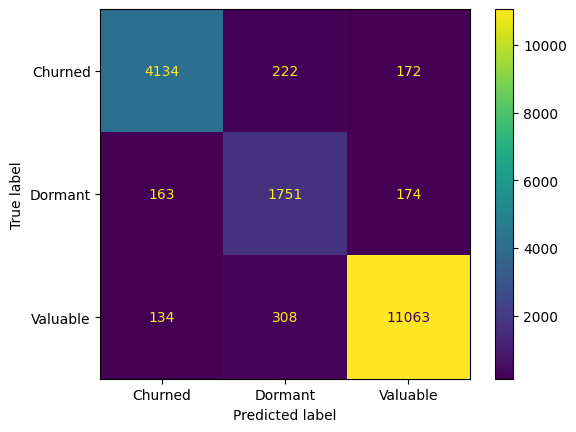

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)


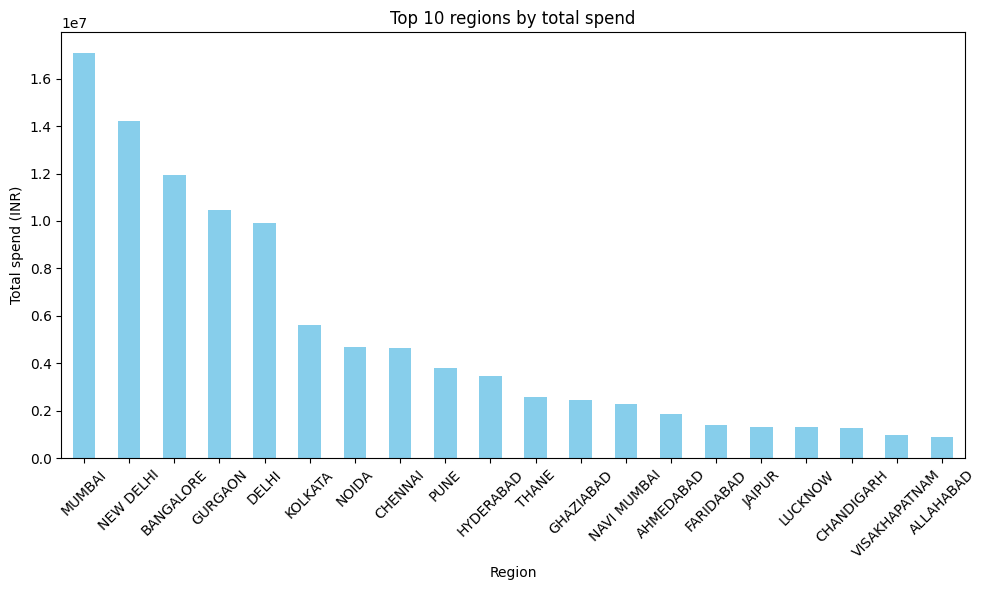

In [20]:
top_regions = customer_df.groupby('Location')['TotalSpend'].sum().nlargest(20)

plt.figure(figsize=(10,6))
top_regions.plot(kind='bar', color='skyblue')
plt.title("Top 10 regions by total spend")
plt.xlabel("Region")
plt.ylabel("Total spend (INR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

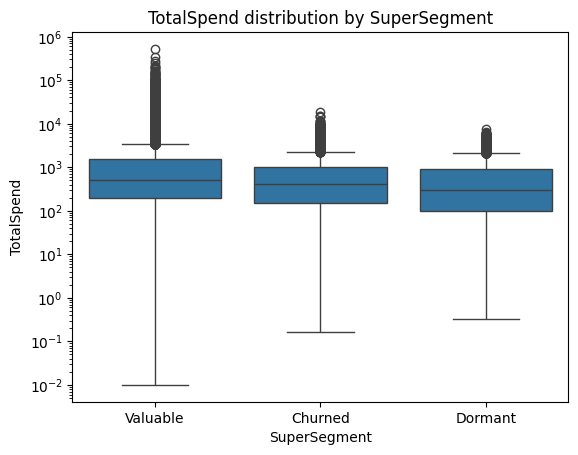

In [21]:
customer_labeled.groupby('SuperSegment')['TotalSpend'].describe()

import seaborn as sns
sns.boxplot(data=customer_labeled, x='SuperSegment', y='TotalSpend')
plt.yscale('log')
plt.title("TotalSpend distribution by SuperSegment")
plt.show()

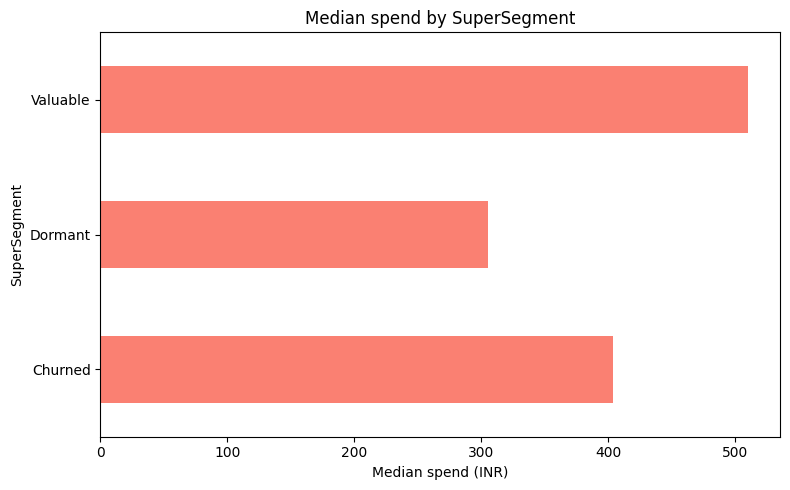

In [22]:
segment_spend = customer_labeled.groupby('SuperSegment')['TotalSpend'].median()

plt.figure(figsize=(8,5))
segment_spend.plot(kind='barh', color='salmon')
plt.title("Median spend by SuperSegment")
plt.xlabel("Median spend (INR)")
plt.ylabel("SuperSegment")
plt.tight_layout()
plt.show()

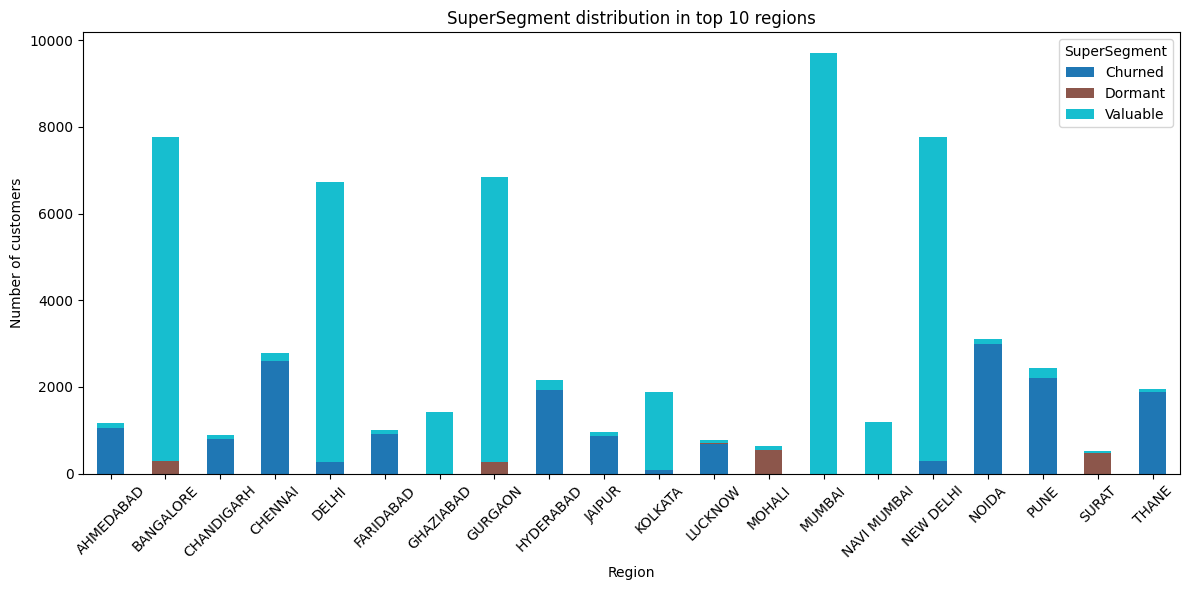

In [23]:
top_regions = customer_labeled['Location'].value_counts().nlargest(20).index
segment_region_top = pd.crosstab(
    customer_labeled[customer_labeled['Location'].isin(top_regions)]['Location'],
    customer_labeled['SuperSegment']
)

segment_region_top.plot(kind='bar', stacked=True, figsize=(12,6), colormap= 'tab10')
plt.title("SuperSegment distribution in top 10 regions")
plt.xlabel("Region")
plt.ylabel("Number of customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

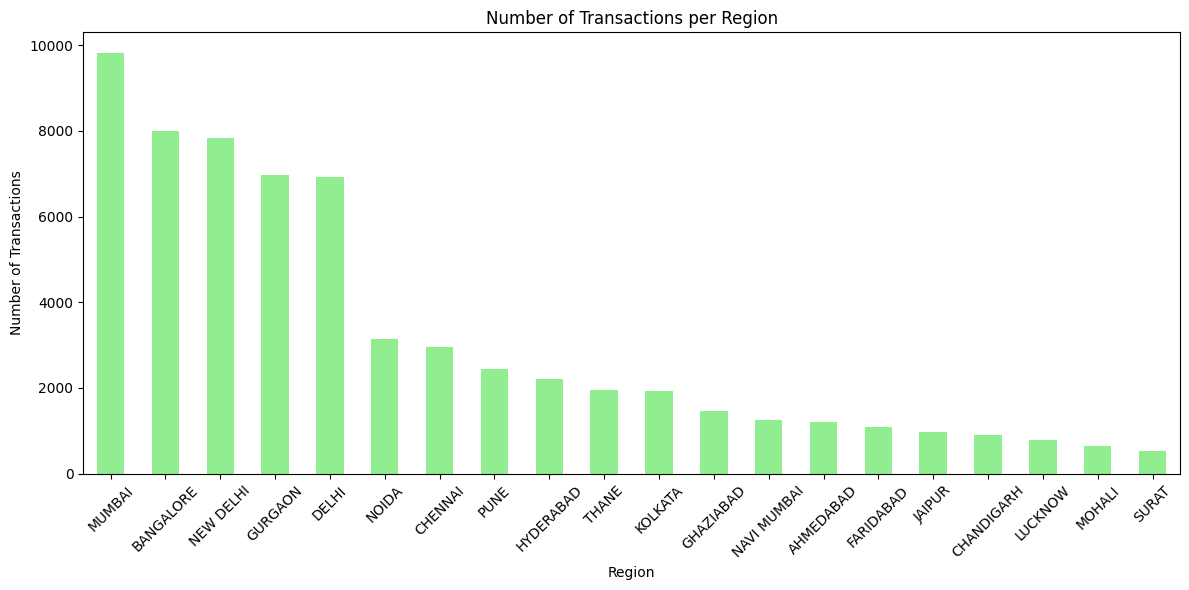

In [24]:
region_txns = customer_labeled.groupby('Location')['NumTxns'].sum().sort_values(ascending=False).nlargest(20)

plt.figure(figsize=(12,6))
region_txns.plot(kind='bar', color='lightgreen')
plt.title("Number of Transactions per Region")
plt.xlabel("Region")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

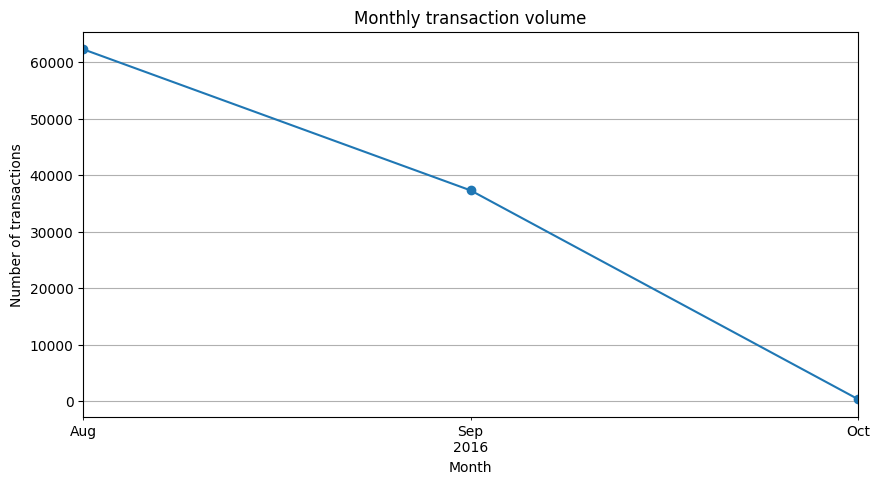

In [25]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['TransactionMonth'] = df['TransactionDate'].dt.to_period('M')

monthly_txn = df.groupby('TransactionMonth').size()

monthly_txn.plot(kind='line', figsize=(10, 5), marker='o')
plt.title("Monthly transaction volume")
plt.ylabel("Number of transactions")
plt.xlabel("Month")
plt.grid(True)
plt.show()

Available columns: ['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance', 'TransactionDate', 'TransactionAmount_INR', 'Age', 'TransactionHour', 'TransactionMinute', 'TransactionSecond', 'TransactionDateTime']
Estimated Uplift@30%: 0.4688888888888889


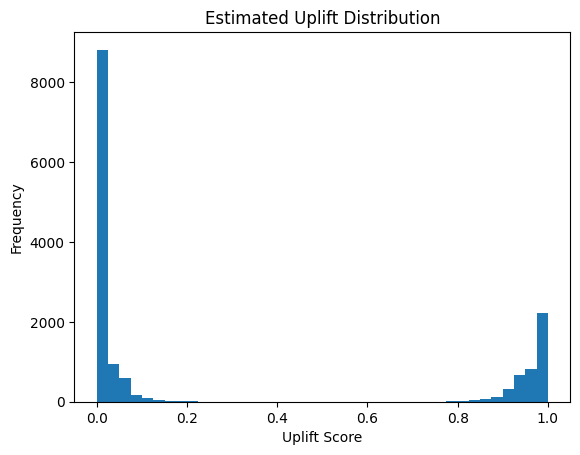

In [26]:
# uplift_model_sim.py (no sklift)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

df = df_train.sample(n=50000, random_state=42)
print("Available columns:", df.columns.tolist())

TRANSACTION_COL = 'TransactionAmount_INR'

df['treatment'] = np.random.choice([0, 1], size=len(df))

df['response'] = ((df[TRANSACTION_COL] > 1000) & (df['treatment'] == 1)).astype(int)

features = [
    'CustAccountBalance', TRANSACTION_COL, 'TransactionHour',
    'CustGender', 'CustLocation'
]
df = df[features + ['treatment', 'response']].dropna()

df = df.sample(n=50000, random_state=42)

df = pd.get_dummies(df, columns=['CustGender', 'CustLocation'], drop_first=True)

X = df.drop(columns=['treatment', 'response'])
y = df['response']
t = df['treatment']

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, t, test_size=0.3, random_state=42
)

def split_by_treatment(X, y, t):
    mask_t = t == 1
    mask_c = t == 0
    return X[mask_t], y[mask_t], X[mask_c], y[mask_c]

X_t, y_t, X_c, y_c = split_by_treatment(X_train, y_train, t_train)

clf_t = RandomForestClassifier(n_estimators=100, random_state=42)
clf_c = RandomForestClassifier(n_estimators=100, random_state=42)
clf_t.fit(X_t, y_t)
clf_c.fit(X_c, y_c)

proba_t = clf_t.predict_proba(X_test)
proba_c = clf_c.predict_proba(X_test)

proba_t = proba_t[:, 1] if proba_t.shape[1] > 1 else np.zeros(len(X_test))
proba_c = proba_c[:, 1] if proba_c.shape[1] > 1 else np.zeros(len(X_test))

uplift = proba_t - proba_c

def uplift_at_k(y_true, uplift_scores, k=0.3):
    k_count = int(len(uplift_scores) * k)
    top_k_idx = np.argsort(uplift_scores)[-k_count:]
    return y_true.iloc[top_k_idx].mean()

score = uplift_at_k(y_test, uplift, k=0.3)
print("Estimated Uplift@30%:", score)

plt.hist(uplift, bins=40)
plt.title("Estimated Uplift Distribution")
plt.xlabel("Uplift Score")
plt.ylabel("Frequency")
plt.show()


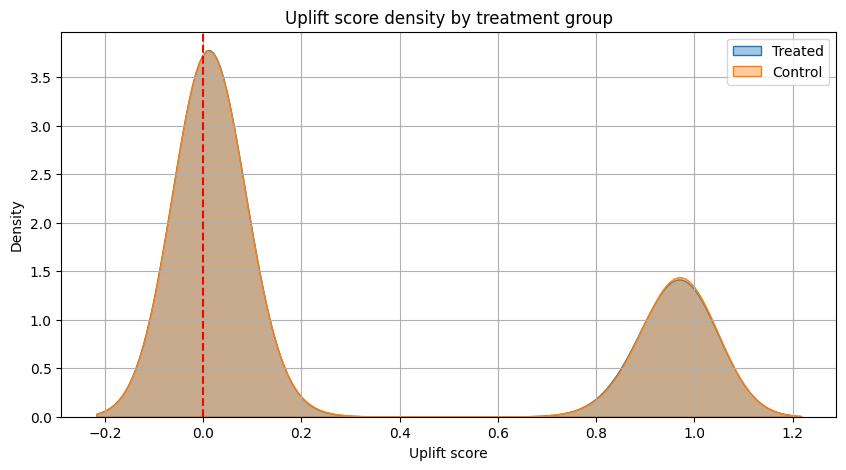

In [27]:
# Add uplift scores back to test set for analysis
uplift_df = X_test.copy()
uplift_df['uplift_score'] = uplift
uplift_df['segment'] = t_test.values  # or use known segment labels if available

# Compare uplift distributions by treatment group
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(uplift_df[uplift_df['segment'] == 1]['uplift_score'], label='Treated', fill=True, alpha=0.4)
sns.kdeplot(uplift_df[uplift_df['segment'] == 0]['uplift_score'], label='Control', fill=True, alpha=0.4)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Uplift score density by treatment group")
plt.xlabel("Uplift score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

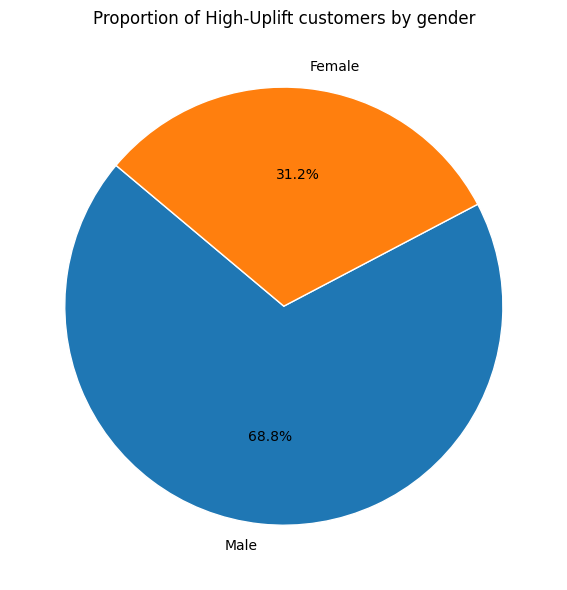

In [28]:
# Proportions
gender_uplift = {
    "Male": X_test[uplift > 0]['CustGender_M'].mean(),
    "Female": 1 - X_test[uplift > 0]['CustGender_M'].mean(),
}

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(gender_uplift.values(), labels=gender_uplift.keys(), autopct='%1.1f%%',
        colors=['#1f77b4', '#ff7f0e'], startangle=140, wedgeprops={'edgecolor': 'white'})
plt.title("Proportion of High-Uplift customers by gender")
plt.tight_layout()
plt.show()


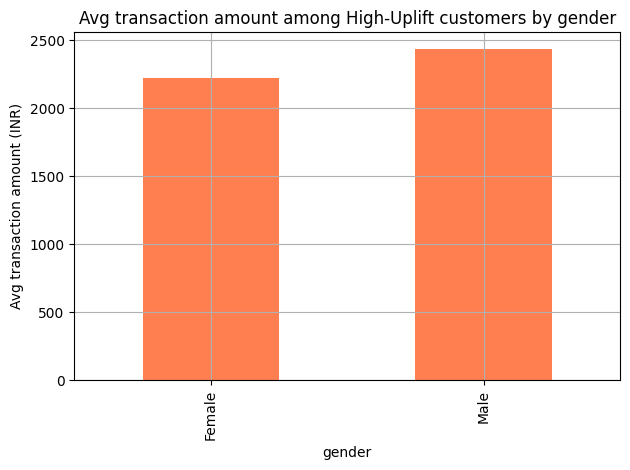

gender
Female    2222.673926
Male      2435.831036
Name: TransactionAmount_INR, dtype: float64


In [29]:
# Define high uplift as uplift > 0
high_uplift_mask = uplift > 0

# Extract high uplift subset
high_uplift_customers = X_test[high_uplift_mask].copy()
high_uplift_customers['uplift_score'] = uplift[high_uplift_mask]
high_uplift_customers['TransactionAmount_INR'] = df.loc[high_uplift_customers.index, 'TransactionAmount_INR']
high_uplift_customers['gender'] = high_uplift_customers['CustGender_M'].apply(lambda x: 'Male' if x == 1 else 'Female')

# Compute average transaction amount per gender
avg_transaction_by_gender = high_uplift_customers.groupby('gender')['TransactionAmount_INR'].mean()

# Plot the result
avg_transaction_by_gender.plot(kind='bar', color='coral')
plt.title("Avg transaction amount among High-Uplift customers by gender")
plt.ylabel("Avg transaction amount (INR)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the values too
print(avg_transaction_by_gender)


In [30]:
# !pip install dash typing_extensions
# !pip install typing_extensions==4.7.1
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np


# Segment counts
segment_df = customer_labeled['SuperSegment'].value_counts().reset_index()
segment_df.columns = ['Segment', 'Count']

# --- Conversion ---
conversion_results = df_results  

# --- Uplift ---
uplift_scores = uplift

# --- Gender split from test data ---
gender_uplift = {
    "Male": X_test[uplift > 0]['CustGender_M'].mean() * 100,
    "Female": 100 - X_test[uplift > 0]['CustGender_M'].mean() * 100
}

#  --- Avg transaction by gender from high uplift customers ---
avg_transaction_by_gender = high_uplift_customers.groupby('gender')['TransactionAmount_INR'].mean()

# CLV vs churn example data
n_points = 1000
clv_pred = np.random.normal(1000, 400, n_points)
churn_prob = np.clip(np.random.beta(2, 5, n_points), 0, 1)
true_churn = np.random.choice([0, 1], size=n_points, p=[0.8, 0.2])

# --- Dash App ---
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Customer Analytics Dashboard"),

    # Segment Distribution
    html.Div([
        html.H2("Customer Segment Distribution"),
        dcc.Graph(
            id='segment-dist',
            figure=px.bar(
                segment_df,
                x='Segment',
                y='Count',
                color='Segment',
                color_discrete_map={
                    'Valuable': 'forestgreen',
                    'Dormant': 'gray',
                    'Churned': 'crimson'
                },
                title="Customer Counts by Segment",
                labels={"Count": "Number of Customers", "Segment": "Segment"}
    )
)
    ]),

    # Conversion uplift simulation results table
    html.Div([
        html.H2("Conversion Uplift Simulation Results"),
        dash.dash_table.DataTable(
            id='conversion-table',
            columns=[{"name": i, "id": i} for i in conversion_results.columns],
            data=conversion_results.to_dict('records'),
            style_table={'overflowX': 'auto'},
            style_cell={'textAlign': 'center'},
            style_header={'fontWeight': 'bold'},
            style_data_conditional=[
                {
                    'if': {'column_id': 'Net Profit (€)'},
                    'color': 'forestgreen',
                    'fontWeight': 'bold'
                }
            ]
        )
    ], style={'marginTop': 30, 'marginBottom': 30}),

    # Financial metrics plot
    html.Div([
        html.H3("Net Profit and Revenue Uplift by Conversion Scenario"),
        dcc.Graph(id='conversion-financials')
    ]),

    # Uplift score distribution
    html.Div([
        html.H2("Uplift Score Distribution"),
        dcc.Graph(
            id='uplift-dist',
            figure=px.histogram(x=uplift_scores, nbins=40, title="Distribution of Uplift Scores", color_discrete_sequence=['mediumseagreen'])
            .add_vline(x=0, line_dash="dash", line_color="crimson")
            .update_layout(xaxis_title="Uplift Score", yaxis_title="Frequency")
        )
    ]),

    # High uplift gender pie chart
    html.Div([
        html.H2("High-Uplift Customer Gender Proportion"),
        dcc.Graph(
            id='gender-pie',
            figure=px.pie(
                names=list(gender_uplift.keys()),
                values=list(gender_uplift.values()),
                title="Proportion of High-Uplift Customers by Gender",
                color=list(gender_uplift.keys()),
                color_discrete_map={'Male': 'mediumseagreen', 'Female': 'lightcoral'}
            )
        )
    ]),

    # Avg transaction amount bar chart
    html.Div([
        html.H2("Average Transaction Amount Among High-Uplift Customers"),
        dcc.Graph(
            id='avg-trans-amount',
            figure=px.bar(
                x=avg_transaction_by_gender.index,
                y=avg_transaction_by_gender.values,
                labels={'x': 'Gender', 'y': 'Avg Transaction Amount (INR)'},
                title="Average Transaction Amount by Gender",
                color=avg_transaction_by_gender.index,
                color_discrete_map={'Male': 'mediumseagreen', 'Female': 'lightcoral'}
            )
        )
    ]),

    # CLV vs Churn scatter plot
    html.Div([
        html.H2("Predicted CLV vs Churn Probability"),
        dcc.Graph(
            id='clv-churn-scatter',
            figure=px.scatter(
                x=clv_pred,
                y=churn_prob,
                color=true_churn.astype(str),
                color_discrete_map={'0': 'lightcoral', '1': 'mediumseagreen'},
                labels={"x": "Predicted CLV", "y": "Predicted Churn Probability", "color": "True Churn"},
                title="CLV vs Churn Probability Scatter Plot"
            )
        )
    ])
])


@app.callback(
    Output('conversion-financials', 'figure'),
    Input('conversion-table', 'data')
)
def update_conversion_financials(rows):
    df = pd.DataFrame(rows)
    fig = go.Figure()
    for label, group in df.groupby("From → To"):
        fig.add_trace(go.Scatter(
            x=group["Conversion Rate"],
            y=group["Net Profit (€)"],
            mode='lines+markers',
            name=f"{label} - Net Profit"
        ))
        fig.add_trace(go.Scatter(
            x=group["Conversion Rate"],
            y=group["Total Revenue Uplift (€)"],
            mode='lines+markers',
            name=f"{label} - Revenue Uplift",
            line=dict(dash='dash', color="forestgreen")
        ))
    fig.update_layout(
        yaxis_title="Amount (€)",
        xaxis_title="Conversion Rate",
        title="Net Profit and Revenue Uplift by Conversion Scenario",
        legend_title="Scenario / Metric"
    )
    return fig


if __name__ == '__main__':
    app.run(debug=True, port=8051)
